In [2]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
from tqdm import tqdm,tqdm_notebook
from prettytable import PrettyTable
import pickle
import os
print('CWD is ',os.getcwd())

# Vis Libs..
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["axes.grid"] = False

# Image Libs.
from PIL import Image
import cv2

# DL Libs..
import keras
from keras import applications
from keras.preprocessing.image import ImageDataGenerator,img_to_array,array_to_img,load_img
from keras import optimizers,Model,Sequential
from keras.layers import Input,GlobalAveragePooling2D,Dropout,Dense,Activation
from keras.callbacks import EarlyStopping,ReduceLROnPlateau

CWD is  C:\Users\lenovo\Music\Semlong\Data Analysis


In [3]:
def load_data():
    train = pd.read_csv('train.csv')
    test = pd.read_csv('test.csv')
    
    train_dir = os.path.join('./','train_images/')
    test_dir = os.path.join('./','test_images/')
    
    train['file_path'] = train['id_code'].map(lambda x: os.path.join(train_dir,'{}.png'.format(x)))
    test['file_path'] = test['id_code'].map(lambda x: os.path.join(test_dir,'{}.png'.format(x)))
    
    train['file_name'] = train["id_code"].apply(lambda x: x + ".png")
    test['file_name'] = test["id_code"].apply(lambda x: x + ".png")
    
    train['diagnosis'] = train['diagnosis'].astype(str)
    
    return train,test

In [4]:
df_train,df_test = load_data()
print(df_train.shape,df_test.shape,'\n')
df_train.head(6)

(3662, 4) (1928, 3) 



,id_code,diagnosis,file_path,file_name
0,000c1434d8d7,2,./train_images/000c1434d8d7.png,000c1434d8d7.png
1,001639a390f0,4,./train_images/001639a390f0.png,001639a390f0.png
2,0024cdab0c1e,1,./train_images/0024cdab0c1e.png,0024cdab0c1e.png
3,002c21358ce6,0,./train_images/002c21358ce6.png,002c21358ce6.png
4,005b95c28852,0,./train_images/005b95c28852.png,005b95c28852.png
5,0083ee8054ee,4,./train_images/0083ee8054ee.png,0083ee8054ee.png


In [5]:
def plot_classes(df):
    df_group = pd.DataFrame(df.groupby('diagnosis').agg('size').reset_index())
    df_group.columns = ['diagnosis','count']

    sns.set(rc={'figure.figsize':(10,5)}, style = 'whitegrid')
    sns.barplot(x = 'diagnosis',y='count',data = df_group,palette = "Blues_d")
    plt.title('Output Class Distribution')
    plt.show()

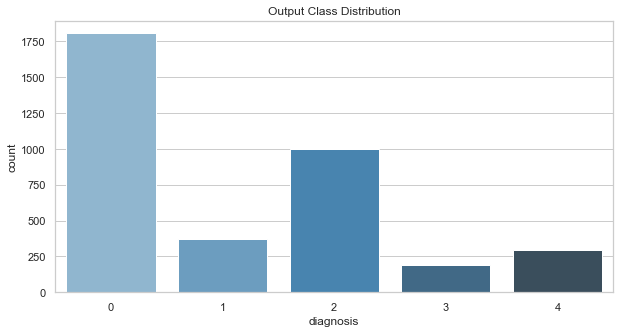

In [6]:
plot_classes(df_train)

In [7]:
IMG_SIZE = 200

In [8]:
def conv_gray(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
    return img

In [12]:
def visualize_imgs(df,pts_per_class,color_scale):
    df = df.groupby('diagnosis',group_keys = False).apply(lambda df: df.sample(pts_per_class))
    df = df.reset_index(drop = True)
    
    plt.rcParams["axes.grid"] = False
    for pt in range(pts_per_class):
        f, axarr = plt.subplots(1,5,figsize = (15,15))
        axarr[0].set_ylabel("Sample Data Points")
        
        df_temp = df[df.index.isin([pt + (pts_per_class*0),pt + (pts_per_class*1), pt + (pts_per_class*2),pt + (pts_per_class*3),pt + (pts_per_class*4)])]
        for i in range(5):
            if color_scale == 'gray':
                img = conv_gray(cv2.imread(df_temp.file_path.iloc[i]))
                axarr[i].imshow(img,cmap = color_scale)    
            else:
                axarr[i].imshow(Image.open(df_temp.file_path.iloc[i]).resize((IMG_SIZE,IMG_SIZE)))
            axarr[i].set_xlabel('Class '+str(df_temp.diagnosis.iloc[i]))

        plt.show()

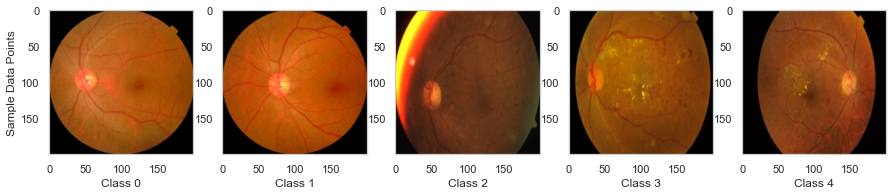

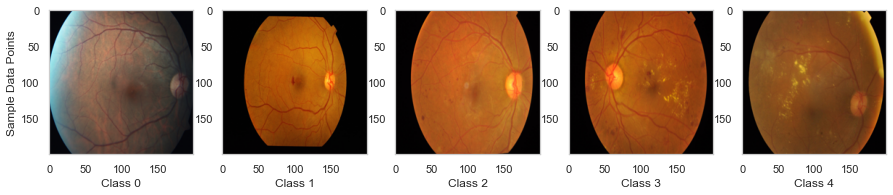

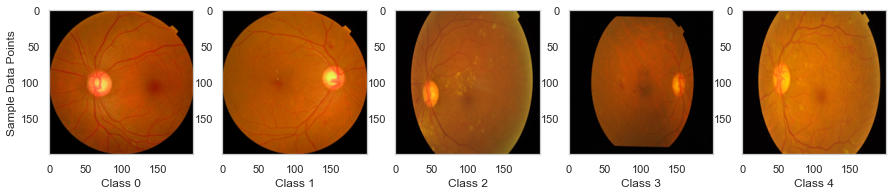

In [13]:
visualize_imgs(df_train,3,color_scale = None)

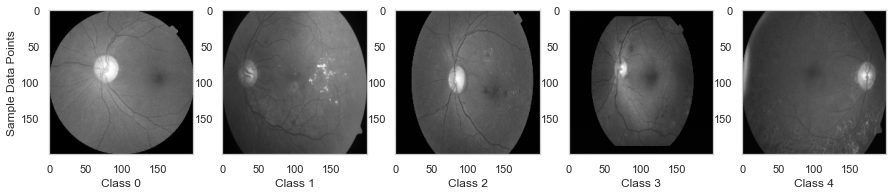

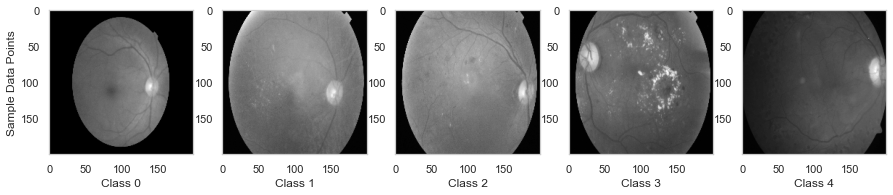

In [14]:
visualize_imgs(df_train,2,color_scale = 'gray')

(array([6.950e+03, 1.165e+03, 1.260e+02, 8.000e+01, 3.200e+01, 3.400e+01,
        1.800e+01, 1.900e+01, 1.500e+01, 1.800e+01, 8.000e+00, 7.000e+00,
        1.300e+01, 1.800e+01, 1.100e+01, 4.000e+00, 1.700e+01, 4.000e+00,
        6.000e+00, 6.000e+00, 1.300e+01, 1.200e+01, 7.000e+00, 1.800e+01,
        1.500e+01, 2.900e+01, 3.600e+01, 1.170e+02, 1.490e+02, 4.180e+02,
        6.730e+02, 5.720e+02, 1.251e+03, 1.018e+03, 2.303e+03, 2.023e+03,
        4.044e+03, 3.271e+03, 4.655e+03, 2.280e+03, 2.564e+03, 2.391e+03,
        1.185e+03, 9.690e+02, 2.970e+02, 2.380e+02, 1.060e+02, 1.070e+02,
        5.400e+01, 6.500e+01, 5.700e+01, 3.700e+01, 3.400e+01, 3.800e+01,
        4.900e+01, 3.500e+01, 5.100e+01, 2.500e+01, 3.200e+01, 2.900e+01,
        2.500e+01, 2.900e+01, 2.100e+01, 3.100e+01, 2.100e+01, 1.700e+01,
        1.100e+01, 8.000e+00, 5.000e+00, 4.000e+00, 1.000e+00, 3.000e+00,
        4.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

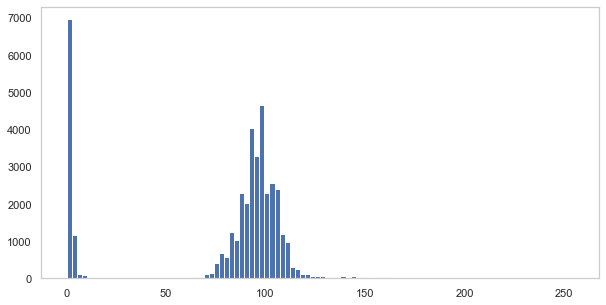

In [15]:
rn = np.random.randint(low = 0,high = len(df_train) - 1)
img = conv_gray(cv2.imread(df_train.file_path.iloc[rn]))
equ = cv2.equalizeHist(img)
plt.hist(img.flat, bins=100, range=(0, 255))

(array([2455.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0., 3934.,    0.,  913.,    0.,  761.,  349.,  443.,  182.,
         400.,  208.,  605.,  384.,    0.,  470.,  568.,    0.,  604.,
         632.,    0.,  638.,    0.,  778.,    0.,  770.,    0.,  826.,
           0.,    0.,  827.,    0.,  812.,    0.,  891.,    0.,    0.,
        1019.,    0.,  986.,    0.,    0.,  954.,    0.,  941.,    0.,
           0.,  953.,    0.,    0., 1006.,    0.,  939.,    0.,    0.,
         970.,    0.,  882.,    0.,  819.,    0.,  752.,    0.,  729.,
           0.,  664.,    0.,  639.,  662.,    0.,  621.,    0.,  536.,
         519.,  458.,  434.,    0.,  776.,  333.,  337.,  282.,  518.,
         477.,  230.,  417.,  351.,  355.,  351.,  442.,  383.,  445.,
         370.]),
 array([  0.  ,   2.55,   5.1 ,   7.65,  10.2 ,  12.75,  15.3 ,  17.85,
         20.4 ,  22.95,  25.5 ,  28.05,  30.6 ,  33.15,  35.7 ,  38.25,
         40.8 ,  43.35,  45.9 ,  48.45,  51.  ,  53.55,  5

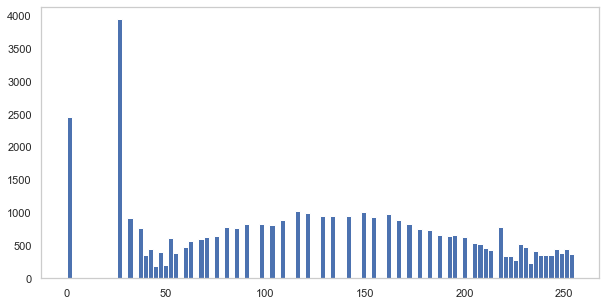

In [17]:
rn = np.random.randint(low = 0,high = len(df_train) - 1)
img = conv_gray(cv2.imread(df_train.file_path.iloc[rn]))
equ = cv2.equalizeHist(img)
plt.hist(equ.flat, bins=100, range=(0, 255))

In [18]:
def clahe(img):
    clahe = cv2.createCLAHE(clipLimit =2.0, tileGridSize=(8,8))
    cl_img = clahe.apply(img)
    return cl_img

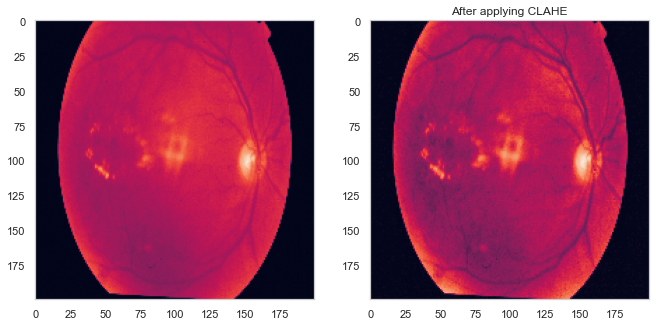

In [19]:
rn = np.random.randint(low = 0,high = len(df_train) - 1)

img = conv_gray(cv2.imread(df_train.file_path.iloc[rn]))
img_t = clahe(img)
f, axarr = plt.subplots(1,2,figsize = (11,11))
axarr[0].imshow(img)
axarr[1].imshow(img_t)
plt.title('After applying CLAHE')
plt.show()

In [20]:
def hough(img):
    #img = cv2.medianBlur(img,5)
    #cimg = cv2.cvtColor(img,cv2.COLOR_GRAY2BGR)
    circles = cv2.HoughCircles(img,cv2.HOUGH_GRADIENT,1,20,
                            param1=50,param2=30,minRadius=0,maxRadius=0)
    circles = np.uint16(np.around(circles))
    for i in circles[0,:]:
        cv2.circle(img,(i[0],i[1]),i[2],(0,255,0),2)    
    return img   

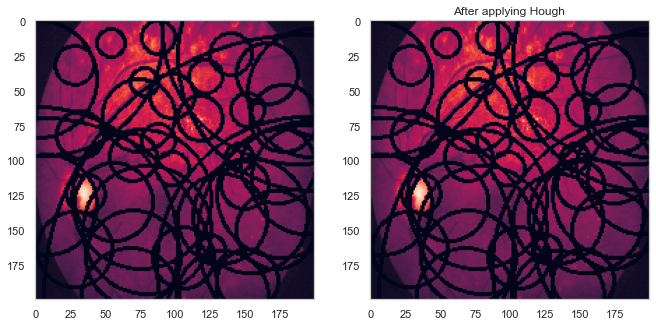

In [21]:
rn = np.random.randint(low = 0,high = len(df_train) - 1)

img = conv_gray(cv2.imread(df_train.file_path.iloc[rn]))
img_c = clahe(img)
img_h = hough(img_c)
f, axarr = plt.subplots(1,2,figsize = (11,11))
axarr[0].imshow(img_c)
axarr[1].imshow(img_h)
plt.title('After applying Hough')
plt.show()

In [23]:
def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
    #         print(img1.shape,img2.shape,img3.shape)
            img = np.stack([img1,img2,img3],axis=-1)
    #         print(img.shape)
        return img
    
    
def circle_crop(img, sigmaX):    
    img = crop_image_from_gray(img)    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    height, width, depth = img.shape    
    
    x = int(width/2)
    y = int(height/2)
    r = np.amin((x,y))
    
    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x,y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)
    img = crop_image_from_gray(img)
    img = conv_gray(img)
    img = clahe(img)
    #img=cv2.addWeighted(img,4, cv2.GaussianBlur( img , (0,0) , sigmaX) ,-4 ,128)
    return img

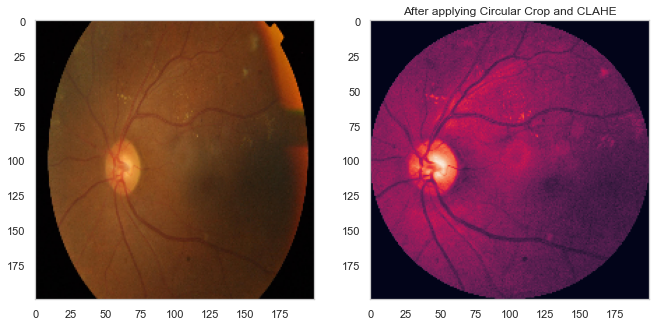

In [24]:
rn = np.random.randint(low = 0,high = len(df_train) - 1)

#img = img_t
img = cv2.imread(df_train.file_path.iloc[rn])
img_t = circle_crop(img,sigmaX = 30)

f, axarr = plt.subplots(1,2,figsize = (11,11))
axarr[0].imshow(cv2.resize(cv2.cvtColor(img, cv2.COLOR_BGR2RGB),(IMG_SIZE,IMG_SIZE)))
axarr[1].imshow(img_t)
plt.title('After applying Circular Crop and CLAHE')
plt.show()

In [25]:
npix = 224 # resize to npix x npix (for now)
X_train = np.zeros((df_train.shape[0], npix, npix))
for i in tqdm_notebook(range(df_train.shape[0])):
    # load an image
    img = cv2.imread(df_train.file_path.iloc[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
    X_train[i, :, :] = cv2.resize(img, (npix, npix)) 
    
print("X_train shape: " + str(np.shape(X_train)))


X_train shape: (3662, 224, 224)


In [26]:
# normalize
X = X_train / 255

# reshape
X = X.reshape(X.shape[0], -1)
trainy = df_train['diagnosis']

In [ ]:
per_vals = [2,5,10,15,20,30,40,50]

for per in tqdm_notebook(per_vals):
    X_decomposed = TSNE(n_components=2,perplexity = per).fit_transform(X)
    df_tsne = pd.DataFrame(data=X_decomposed, columns=['Dimension_x','Dimension_y'])
    df_tsne['Score'] = trainy.values
    
    sns.FacetGrid(df_tsne, hue='Score', size=6).map(plt.scatter, 'Dimension_x', 'Dimension_y').add_legend()
    plt.title('TSNE for perplexity = ' + str(per))
    plt.show()

In [ ]:
def generate_augmentations(lim):
    datagen = ImageDataGenerator(featurewise_center=True,
                                 featurewise_std_normalization=True,
                                 rotation_range=20,
                                 #width_shift_range=0.2,
                                 #height_shift_range=0.2,
                                 horizontal_flip=True)
    img = cv2.imread(df_train.file_path.iloc[np.random.randint(low = 0,high = len(df_train) - 1)])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
    plt.imshow(img)
    plt.title('ORIGINAL IMAGE')
    plt.show()
    
    img_arr = img.reshape((1,) + img.shape)
    
    i = 0
    for img_iterator in datagen.flow(x = img_arr,batch_size = 1):
        i = i + 1
        if i > lim:
            break
        plt.imshow((img_iterator.reshape(img_arr[0].shape)).astype(np.uint8))
        plt.title('IMAGE AUGMENTATION ' + str(i))
        plt.show()